# Lecture 8: Hierarchical models

*This tutorial was presented in lecture 8 and was generated from a Jupyter notebook.  You can download the notebook [here](l08_hierarchical_models.ipynb).*

Before we begin, we import our favorite modules, as always.

In [1]:
import warnings

import numpy as np
import scipy.stats as st

# BE/Bi 103 utilities
import bebi103

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## A sample calculation

We will do MCMC on the hierarchical posterior derived in class for worm reversal data.  Specifically,

\begin{align}
P(q, \kappa,\mathbf{p}\mid \mathbf{r}, \mathbf{n},I) \propto
P(\mathbf{r},\mathbf{n}\mid \mathbf{p}, I)\,
\left(\prod_{i=1}^k P(p_i\mid q,\kappa)\right)\, P(q\mid I)\,P(\kappa\mid I),
\end{align}

where

\begin{align}
P(p_i\mid q, \kappa) =  \frac{\Gamma(\kappa)}{\Gamma(q(\kappa - 2) + 1)\Gamma((1-q)(\kappa - 2) + 1)}\,
p^{q(\kappa - 2)}(1-p)^{(1-q)(\kappa - 2)},
\end{align}

and $p(q\mid I)$ and $p(\kappa\mid I)$ are both constants, defined
respectively on $0\le q \le 1$ and $\kappa > 2$.  As before, we have a
binomial likelihood, where we assume the experiments are independent.

\begin{align}
P(\mathbf{r},\mathbf{n}\mid \mathbf{p}, I) = \prod_{i=1}^k \frac{n_i!}{(n_i-r_i)!r_i!}\,
p_i^{r_i}(1-p_i)^{n_i-r_i}.
\end{align}

First, we'll fabricate some data of worm reversal experiments.

In [2]:
# Fabricate data
r = np.array([9, 16, 14, 5, 110])
n = np.array([35, 40, 40, 34, 660])

Next, as usual, we define our log posterior.

In [3]:
def log_prior(params):
    """
    Log prior for q (reversal probability) and kappa (concentration).
    This prior is unnormalized.
    """    
    # Unpack
    q = params[0]
    kappa = params[1]
    p = params[2:]
    
    # Within domains?
    if not (0 <= q <= 1) or np.any(p < 0) or np.any(p > 1) or kappa <= 2:
        return -np.inf
    
    # Compute log beta distribution for conditional probability
    alpha = q * (kappa - 2) + 1
    beta = (1 - q) * (kappa - 2) + 1
    return st.beta._logpdf(p, alpha, beta).sum() - np.log(kappa)


def log_likelihood(params, r, n):
    """
    Log likelihood for worm reversal, binomially distributed
    """
    # Unpack
    p = params[2:]

    return st.binom._logpmf(r, n, p).sum()


def log_posterior(params, r, n):
    """
    Log posterior for worm reversals.
    """
    lp = log_prior(params)
    if lp == -np.inf:
        return -np.inf
    return lp + log_likelihood(params, r, n)

Now, we'll do MCMC with this log posterior.

In [4]:
# Set up calculation
n_walkers = 100
n_burn = 5000
n_steps = 5000
p0 = np.empty((n_walkers, 2 + len(r)))
p0[:,0] = np.random.uniform(0, 1, n_walkers)             # q
p0[:,1] = 2 + np.random.exponential(1, n_walkers)        # kappa
p0[:,2:] = np.random.uniform(0, 1, (n_walkers, len(r)))  # p_i's

# Columns for output
columns = ['q', 'kappa'] + ['p' + str(i) for i in range(1, len(r)+1)]

df = bebi103.run_ensemble_emcee(log_posterior, n_burn, n_steps, n_walkers=100, 
                                p0=p0, columns=columns, args=(r, n), threads=6)

Let's make a corner plot to look at the posterior.

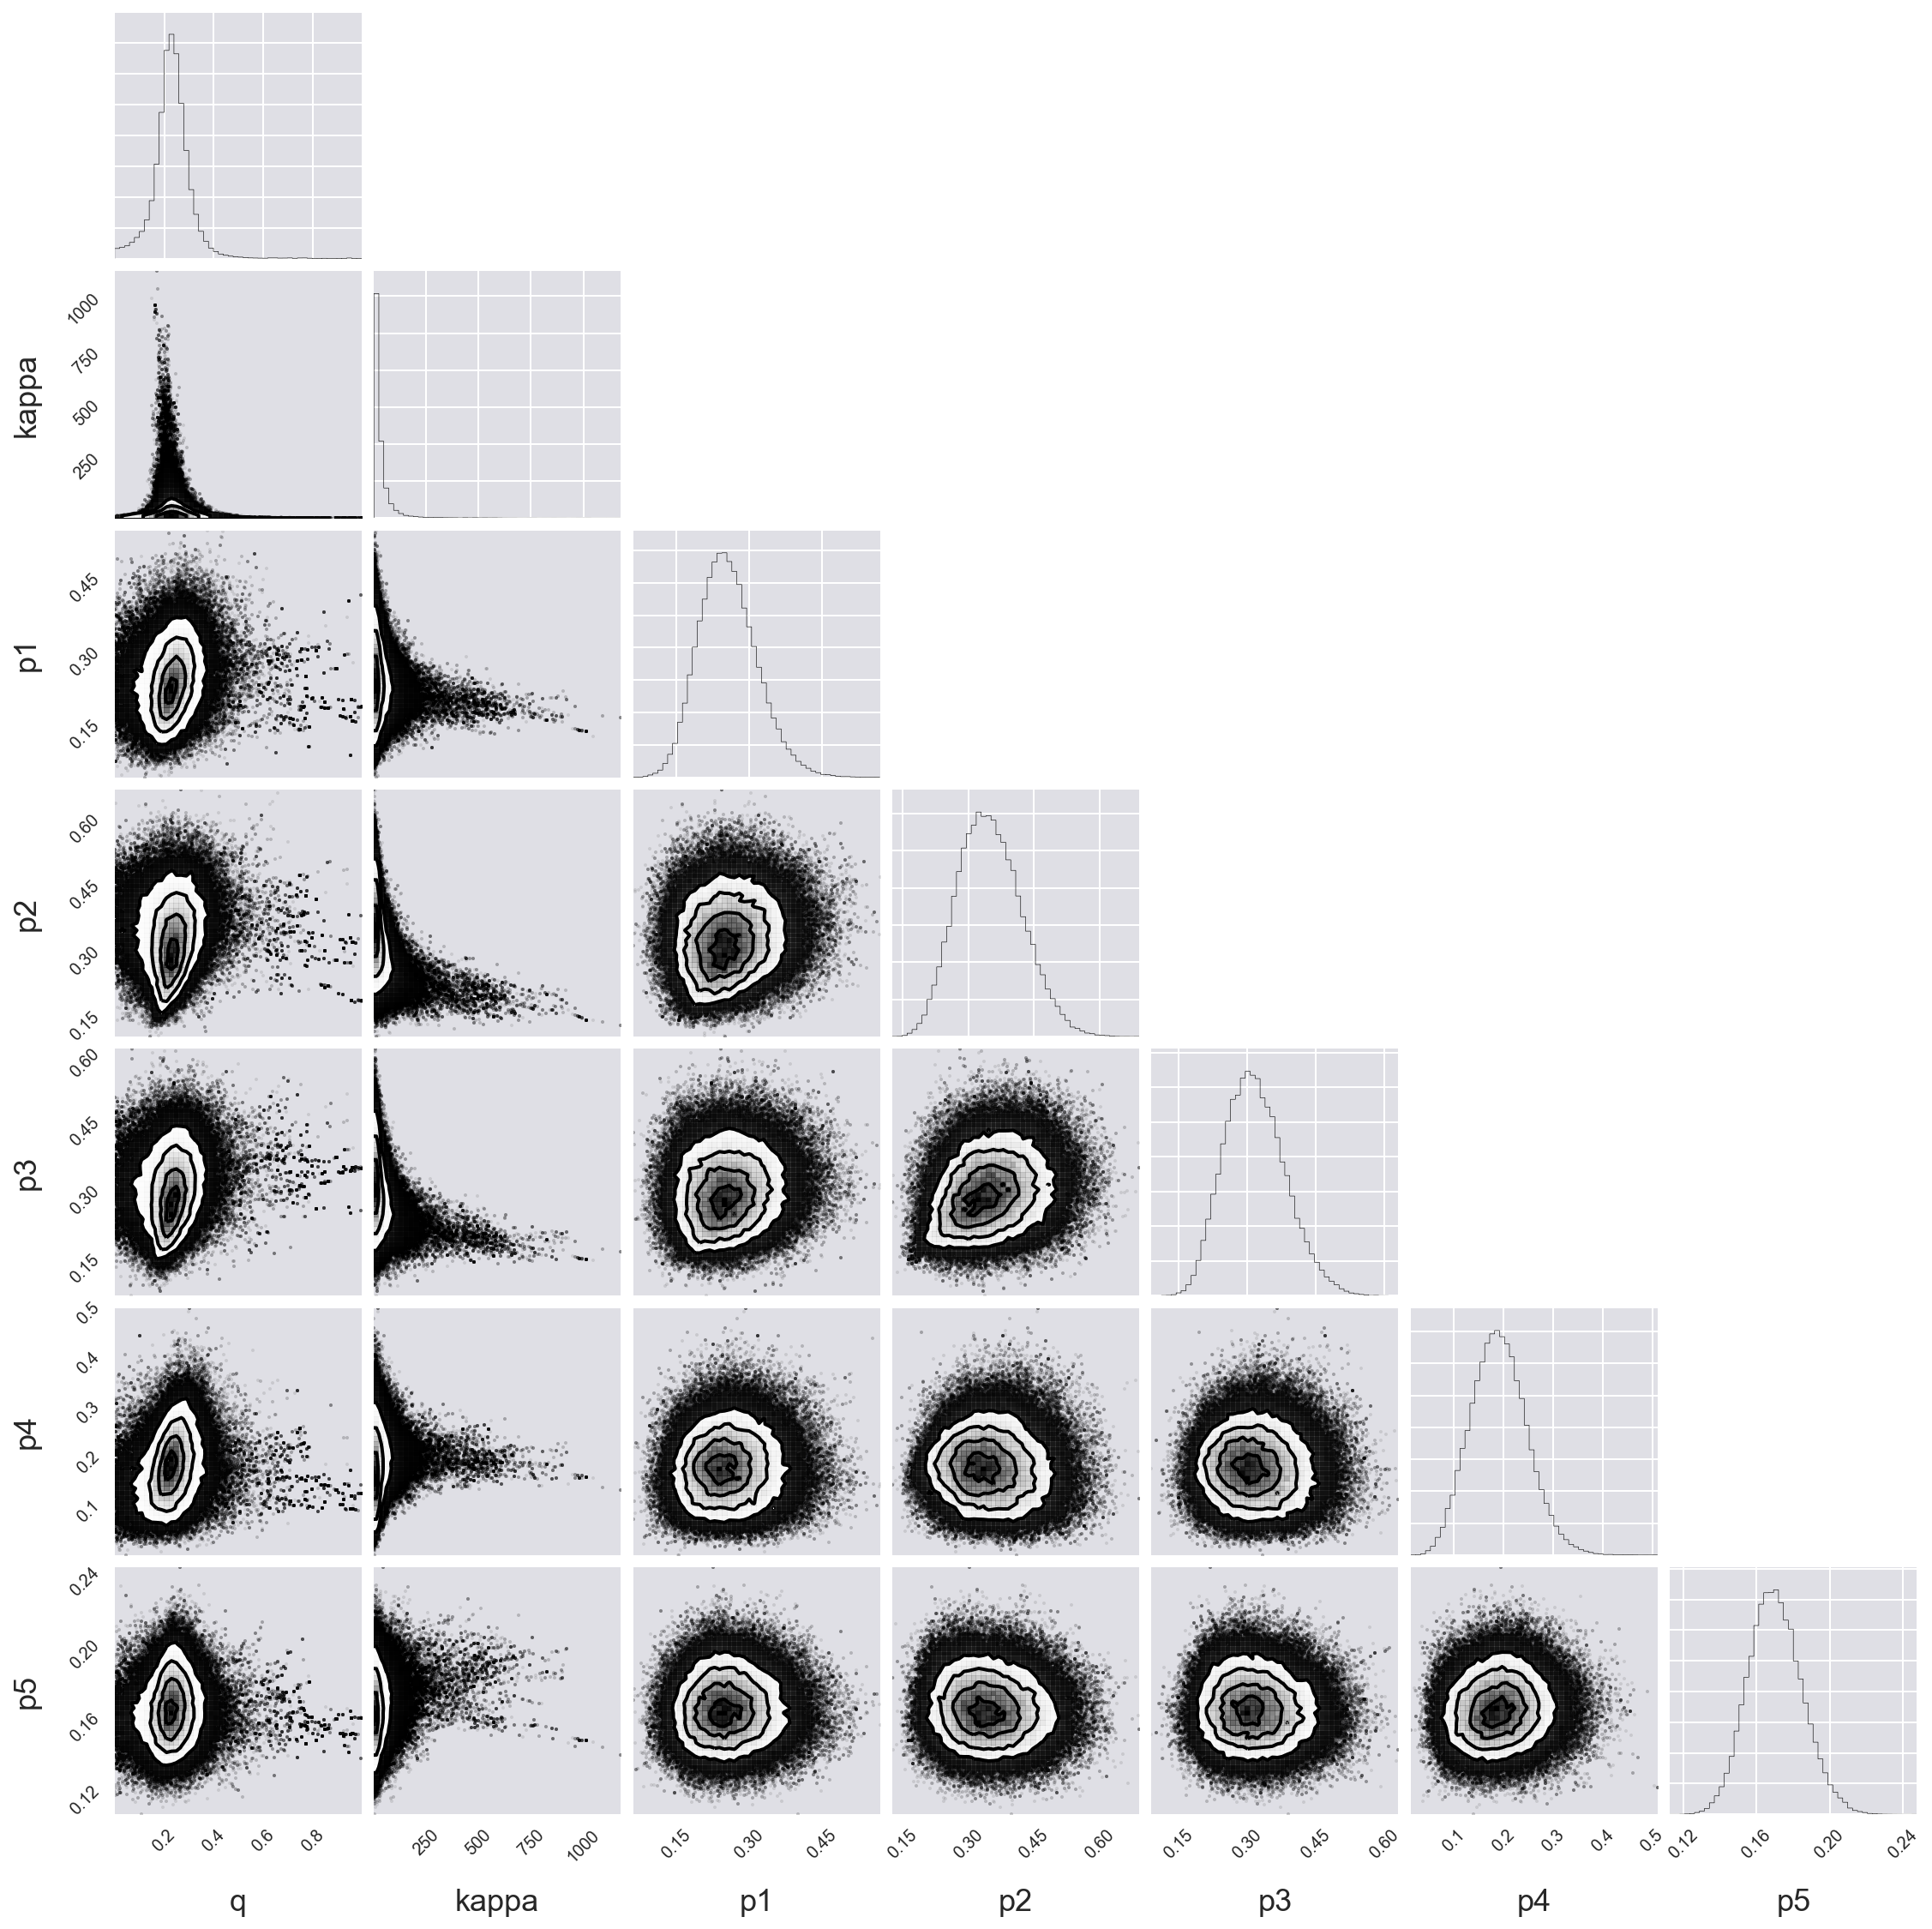

In [5]:
corner.corner(df[columns], bins=50);

We can see the results more clearly if we plot the marginalized distributions on top of each other.  This also allows us to see how the respective experiments serve to determine $q$, the master reversal probability.

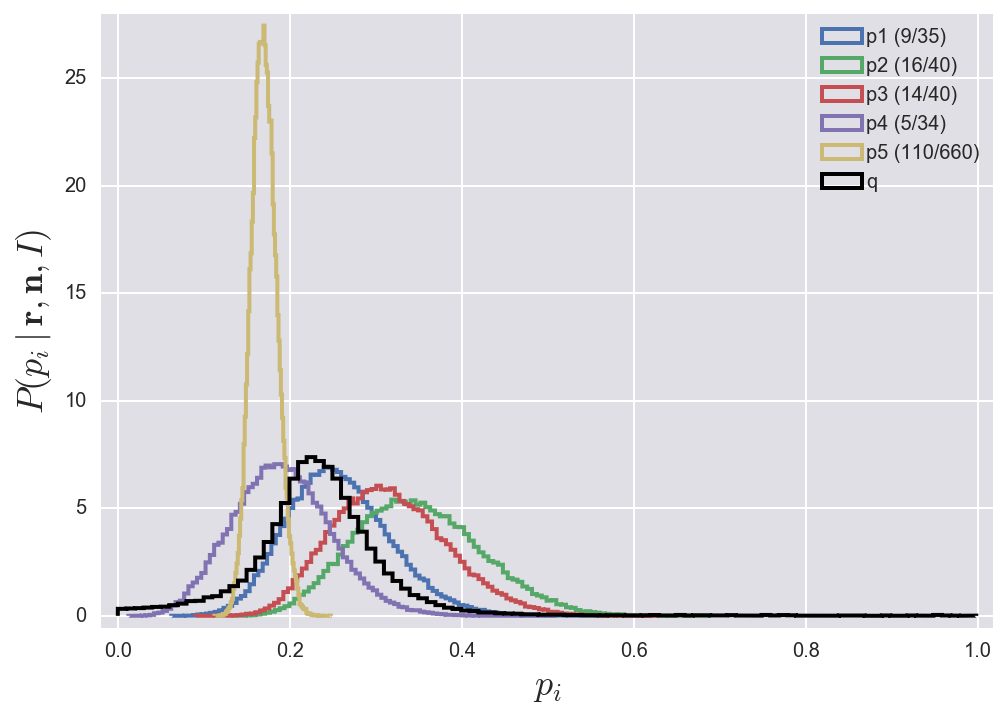

In [6]:
# Plot histograms
for i, p in enumerate(columns[2:]):
    leg_str = 'p{0:d} ({1:d}/{2:d})'.format(i+1, r[i], n[i])
    _ = plt.hist(df[p], normed=True, bins=100, histtype='step', lw=2, 
                 label=leg_str)
_ = plt.hist(df['q'], normed=True, bins=100, histtype='step', lw=2,
             color='black', label='q')

# Clean up
plt.xlabel('$p_i$')
plt.ylabel(r'$P(p_i\mid \mathbf{r},\mathbf{n},I)$')
plt.legend(loc='upper right')
plt.margins(0.02)

Finally, we can compute the most probable $q$ and the 95% HPD.

In [7]:
q = df.loc[np.argmax(df['lnprob']), 'q']
q_hpd = bebi103.hpd(df['q'], 0.95)
print("""
q = [{0:.3f}, {1:.3f}, {2:.3f}]
""".format(q_hpd[0], q, q_hpd[1]))


q = [0.054, 0.235, 0.377]



This makes the longer tail to the left more clear.  This is due to experiment five, which had many samples, but had a low reversal probability.